In [1]:
import detailed_kf_bugtesting as dkf
import kf_standard_bugtesting as skf

from ML_Kalman import Kalman

In [2]:
import numpy as np

########################
# File Data
########################
filename0_ = 'buggy'
savetopath_ = './'

########################
# Bayes Risk Parameters
########################
max_it_BR_ = 2
num_randparams_ = 10
space_size_ = np.arange(-8,3)
truncation_ =20
bayes_params_ = [max_it_BR_, num_randparams_, space_size_,truncation_]

########################
# Experiment Parameters
########################
n_train_ = 2000
n_predict_ = 48
n_testbefore_ = 49
multiplier_ = 20.0 
bandwidth_ = 50.0

exp_params_ = [n_train_, n_predict_, n_testbefore_, multiplier_, bandwidth_]

########################
# Truth Parameters
########################
apriori_f_mean_ = 0.0 
alpha_ = 1.0
f0_ = 10.0
p_ = -1 #1 #-2 #-1 #0.0
J_ = 2
jstart_ = 1 # (not zero)
pdf_type_u_ = 'Uniform'
      
true_noise_params_ = [apriori_f_mean_, pdf_type_u_, alpha_, f0_, p_, J_, jstart_]

########################
# Measurement Noise 
########################
msmt_noise_mean_ = 0.0 
msmt_noise_level_ = 0.01 

msmt_noise_params_ = [msmt_noise_mean_, msmt_noise_level_]

########################
# Kalman Parameters
########################
p0_ = 10000.0 
x0_ = 1.0
optimal_sigma_ = 0.1
optimal_R_ = 0.1
b_delta_ = 0.5 

max_it_ = 5

kalman_params_ = [optimal_sigma_, optimal_R_, x0_, p0_, b_delta_]

########################
# Skip Msmts
########################
skip =1


In [3]:
from ML_Kalman import Kalman

Test_Object = Kalman(filename0_, savetopath_, max_it_,
                     exp_params_, kalman_params_, msmt_noise_params_,
                     true_noise_params_, user_defined_variance=None, 
                     skip_msmts=skip)

First, recreate the error using the base code:

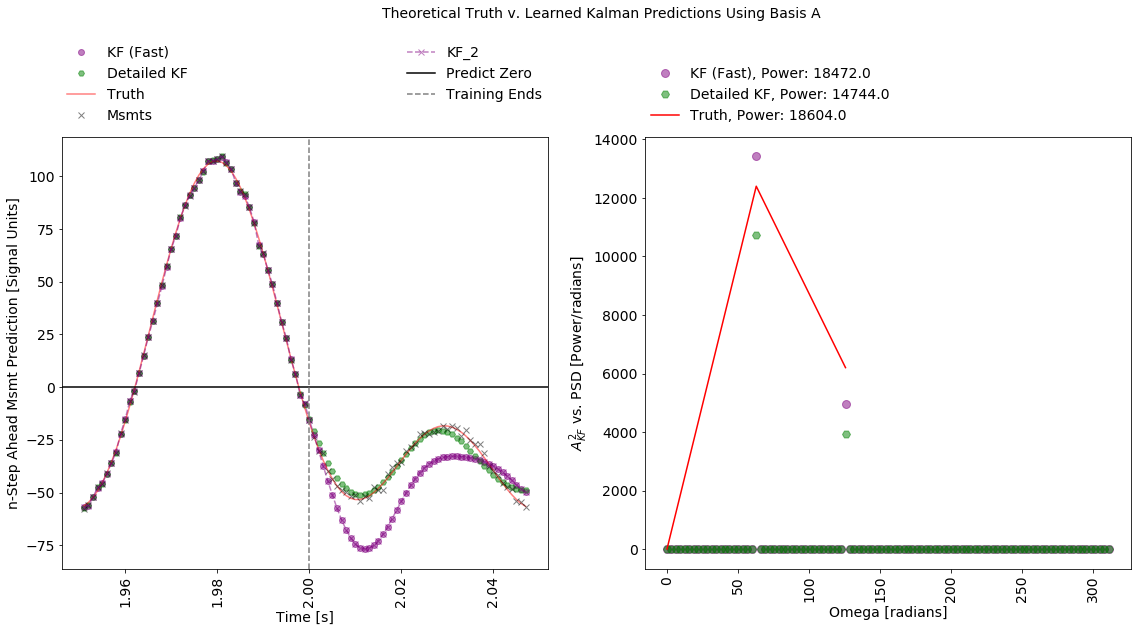

In [4]:
Test_Object.run_test_KF()

Let's plot the relevant trajectories for the intervals (0,220), (400,620), and (1800,2020). This will characterise that the state estimates start off identically, and then diverge:

In [5]:
dkf_data_object = np.load('buggy_kfresults_det_KF_.npz')
skf_data_object = np.load('Check_KF_Results.npz')

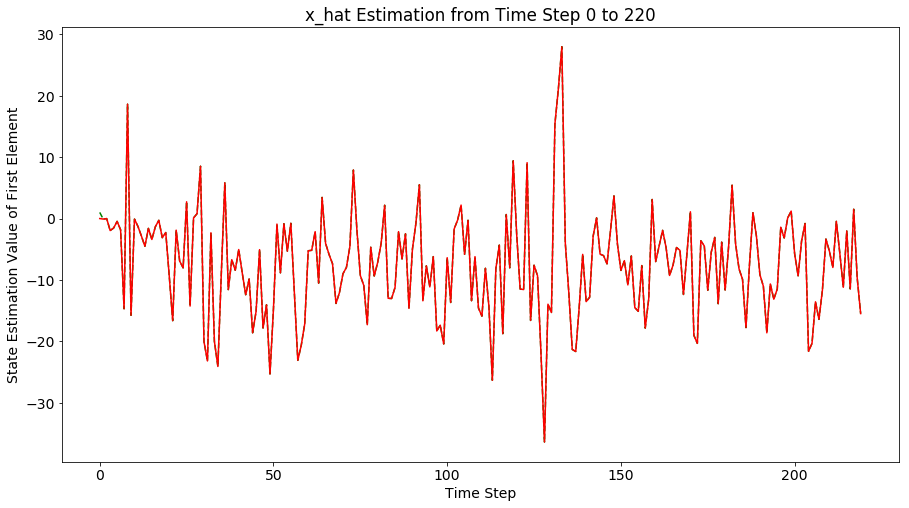

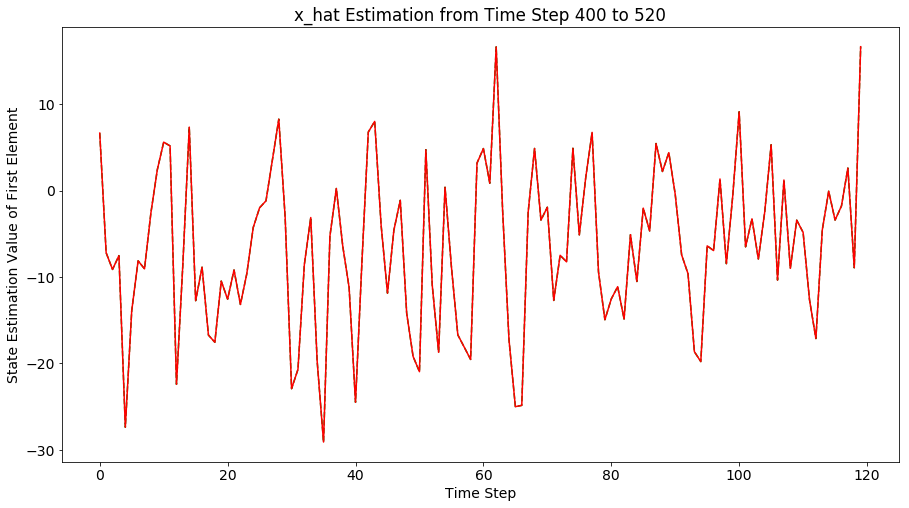

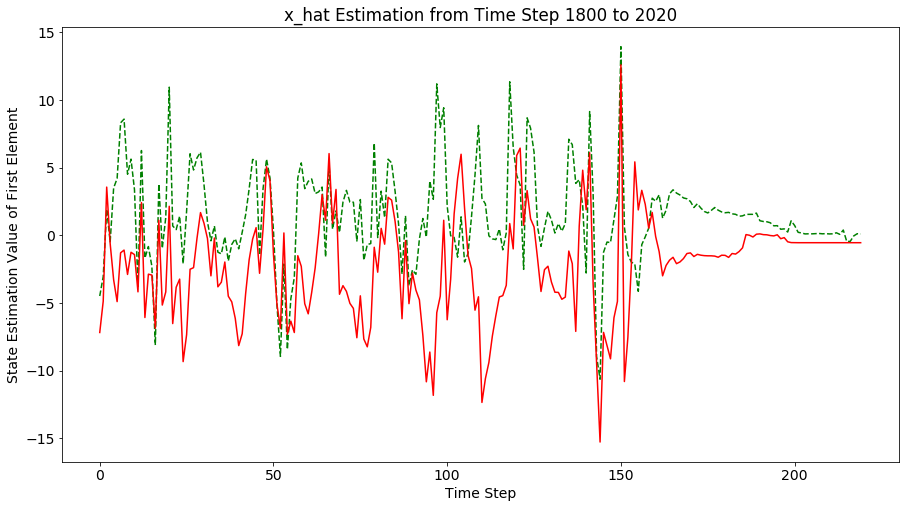

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size']= 14

time_start = [0, 400, 1800]
time_end = [220, 520, 2020]

for i in xrange(3):
    item = 'x_hat'
    plt.figure(figsize=(15,8))
    plt.title('%s Estimation from Time Step %s to %s'%('x_hat', time_start[i], time_end[i]))
    plt.xlabel('Time Step')
    plt.ylabel('State Estimation Value of First Element')
    plt.plot(dkf_data_object['x_hat'][0,0,time_start[i]:time_end[i]], 'g--' )
    plt.plot(skf_data_object['x_hat'][0,0,time_start[i]:time_end[i]], 'r')
    plt.show()


Now I add the bugtesting code. Here, the key difference is in detailed_kf_bugtesting.py

In [7]:
import detailed_kf_bugtesting as bugdkf

In [8]:
truth, signal = Test_Object.generate_data_from_truth(None)

In [9]:
pred_dkf, amps_dkf = Test_Object.detailed_single_prediction(signal)
pred_skf = Test_Object.single_prediction(signal)
pred_skf2, amps_skf = Test_Object.single_prediction(signal, use_skf_amp='Yes')

In [10]:
pred_bugdkf, amps_bugdkf = bugdkf.detailed_kf("Bug_DKF_Resuls", signal, 
                                              n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, 
                                              x0_,p0_, optimal_sigma_, optimal_R_, Test_Object.basisA,
                                              0.0, skip_msmts=1)

In [11]:
bug_dkf_object = np.load('Bug_DKF_Resuls.npz')
dkf_data_object = np.load('buggy_kfresults_det_KF_.npz')
skf_data_object = np.load('Check_KF_Results.npz')

print bug_dkf_object['h'][:,:,0]
print dkf_data_object['h'][:,:,0]
print skf_data_object['h'][:,:]

[[ 1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.]]
[[ 1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
   1.  0.  1.  0.  1.  0. 

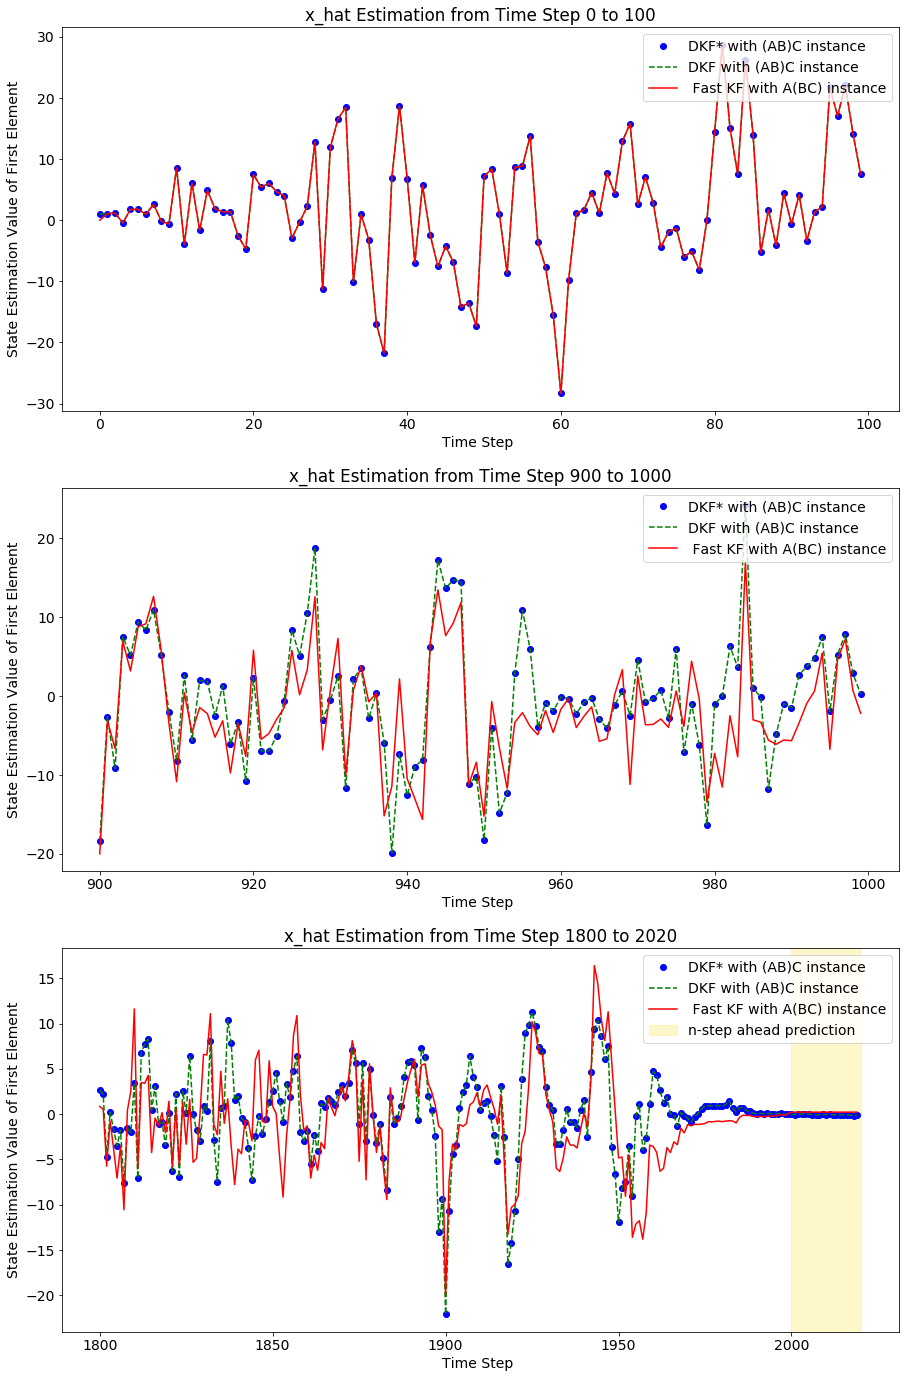

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size']= 14

time_start = [0, 900, 1800]
time_end = [100, 1000, 2020]

plt.figure(figsize=(15,24))
for i in xrange(3):
    item = 'x_hat'
    plt.subplot(3,1,i+1)
    plt.title('%s Estimation from Time Step %s to %s' %('x_hat', time_start[i], time_end[i]))
    plt.xlabel('Time Step ')
    plt.ylabel('State Estimation Value of First Element')
    plt.plot(range(time_start[i], time_end[i], 1), bug_dkf_object['x_hat'][0,0,time_start[i]:time_end[i]],'bo' , label='DKF* with (AB)C instance')
    plt.plot(range(time_start[i], time_end[i], 1), dkf_data_object['x_hat'][0,0,time_start[i]:time_end[i]], 'g--' , label='DKF with (AB)C instance')
    plt.plot(range(time_start[i], time_end[i], 1), skf_data_object['x_hat'][0,0,time_start[i]:time_end[i]], 'r', label=' Fast KF with A(BC) instance')   
    if i==2:
        plt.axvspan(n_train_, time_end[i], ymin=0, ymax=1, color='gold', alpha=0.2, label='n-step ahead prediction ')
    plt.legend(loc=1)

plt.savefig('FIG_Kalman_Bug_DKF_with_Same_Associativity', format="svg")
plt.show()

The bug testing version of the DKF confirms that the following are not the causes for disparity (individually added and tested):
    - Calc_Gamma is not the cause of the disparity
    - Change "twonumf = numf*2" to "twonumf = int(numf*2)"
    - Convert n_converge to n_train in the entire code
    - Changing S_inv to 1.0/S
    - Changing from math.cos to np.cos
    - Optimising using numba
    
The following change has an impact:
    - Changing np.dot(np.dot()) instance to numpy.linalg.multi_dot()
    

In [16]:
#### Create collated SVG figure
import svgutils.transform as sg
import sys 

'''
Filname for compiled image:  'compiled'
'''
#create new SVG figure
fig = sg.SVGFigure("15cm", "24cm")

figureimp = sg.fromfile(str('FIG_Kalman_Bug_DKF_with_Same_Associativity'))
figimp = figureimp.getroot()
figimp.moveto(10,0,scale=0.49)
fig.append(figimp)
fig.save("compiled.svg")

# Export as pdf using Shell
!echo $SHELL
!pwd
!inkscape --export-pdf=FIG_Kalman_Bug_DKF_with_Same_Associativity.pdf compiled.svg
!exit

/bin/bash
/home/riddhisw/Documents/2017/Mar2017/Kalman_Test_Cases/2_Portable_Code/Scripts_Git
